In [1]:
import math
import os
import random
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

from models import TextLSTM, TextTCN
from models_variational import TextLSTM as TextLSTMVariational
from models_variational import TextTCN as TextTCNVariational
from torchtext import data, datasets
from torchtext.vocab import GloVe
from variational import ELBO
from yelp_reviews import YELP

In [2]:
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
rand_state = random.getstate()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 2),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [4]:
def plot(coverages, risks_sr, risks_var, dims):
    plt.figure(figsize=dims)
    plt.plot(coverages, risks_sr, label='SR')
    plt.plot(coverages, risks_var, label='BV')
    plt.legend(loc='lower right')
    plt.xlabel('coverage', fontsize=20)
    plt.ylabel('risk', fontsize=20)
    plt.show()

## Dataset loading

In [5]:
def load_imdb():
    TEXT = data.Field(fix_length=400, lower=True,
                      tokenize='spacy', batch_first=False)
    LABEL = data.LabelField(dtype=torch.long)
    train_data, test_data = datasets.IMDB.splits(
        TEXT, LABEL, root='./data/imdb/')
    train_data, valid_data = train_data.split(
        split_ratio=0.8, stratified=False, random_state=rand_state)
    TEXT.build_vocab(train_data, vectors=GloVe(
    name='6B', dim=100, cache='./glove/'))
    print(len(TEXT.vocab.itos))
    print()
    LABEL.build_vocab(train_data)
    return train_data, valid_data, test_data

def load_sst():
    TEXT = data.Field(fix_length=30, lower=True,
                      tokenize='spacy', batch_first=False)
    LABEL = data.LabelField(dtype=torch.long)
    train_data, valid_data, test_data = datasets.SST.splits(TEXT, LABEL,
                                                            root='./data/sst/',
                                                            fine_grained=False,
                                                            filter_pred=lambda ex:
                                                            ex.label != 'neutral')
    TEXT.build_vocab(train_data, vectors=GloVe(
    name='6B', dim=100, cache='./glove/'))
    LABEL.build_vocab(train_data)
    return train_data, valid_data, test_data

def load_yelp():
    TEXT = data.Field(fix_length=300, lower=True,
                      tokenize='spacy', batch_first=False)
    LABEL = data.LabelField(dtype=torch.long)
    train_data, test_data = YELP.splits(
        TEXT, LABEL, root='./data/yelp/')
    train_data, valid_data = train_data.split(
        split_ratio=0.9, stratified=False, random_state=rand_state)
    TEXT.build_vocab(train_data, vectors=GloVe(
    name='6B', dim=100, cache='./glove/'))
    LABEL.build_vocab(train_data)
    return train_data, valid_data, test_data

## Predictions

In [6]:
def predict(model, iterator):
    def predict_on_batch(model, batch):
        model.eval()
        with torch.no_grad():
            x, y = batch.text, batch.label
            y_pred = model(x)
        return y_pred, y
    
    preds = []
    scores = []
    targets = []
    
    for batch in iterator:
        batch_scores, batch_targets = predict_on_batch(model, batch)
        batch_preds = torch.argmax(batch_scores, dim=1)      
        preds += [batch_preds.cpu().numpy()]
        scores += [batch_scores.cpu().numpy()]
        targets += [batch_targets.cpu().numpy()]
    
    preds = np.hstack(preds)
    scores = np.vstack(scores)
    targets = np.hstack(targets)
    print(preds.shape)
    print(scores.shape)
    print(targets.shape)
    
    return preds, scores, targets

In [7]:
def bbb_predict(model, iterator, T=10):
    def bbb_predict_on_batch(model, batch, T):
        model.eval()
        preds = []
        x, y = batch.text, batch.label
        targets = y
        for _ in range(T):
            with torch.no_grad():
                y_pred = model(x)
                preds += [y_pred]
        preds = torch.stack(preds)
        pred_means = torch.mean(preds, dim=0)
        pred_vars = torch.var(preds, 0, False, False)
        pred_vars = torch.mean(pred_vars, dim=-1)
        return pred_means, targets, pred_vars
    
    preds = []
    scores = []
    targets = []
    variances = []
    
    for batch in iterator:
        batch_scores, batch_targets, batch_vars = bbb_predict_on_batch(model, batch, T)
        batch_preds = torch.argmax(batch_scores, dim=1)      
        preds += [batch_preds.cpu().numpy()]
        scores += [batch_scores.cpu().numpy()]
        targets += [batch_targets.cpu().numpy()]
        variances += [batch_vars.cpu().numpy()]
    
    preds = np.hstack(preds)
    scores = np.vstack(scores)
    targets = np.hstack(targets)
    variances = np.hstack(variances)
    print(preds.shape)
    print(scores.shape)
    print(targets.shape)
    print(variances.shape)
    
    return preds, scores, targets, variances

## Selective risk

In [8]:
def selective_risk_at_coverage(coverage, kappas, preds, targets):
    assert coverage >= 0 and coverage <= 1
    if coverage == 0:
        return 0
    assert preds.shape[0] == targets.shape[0]
    assert kappas.shape[0] == targets.shape[0]
    kappas_sorted = np.sort(kappas)
    if coverage == 1:
        threshold = kappas_sorted[0]
    else:
        threshold = kappas_sorted[-int(coverage * preds.size)]
    covered_idx = kappas > threshold
    if not np.any(covered_idx):
        return 0
    selective_risk = 1 - np.mean(preds[covered_idx] == targets[covered_idx])
    return selective_risk

In [9]:
coverages = np.linspace(0,1,51)
coverages

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

## SST-2

In [10]:
_, valid_data, _ = load_sst()
iterator = data.BucketIterator(valid_data, batch_size=batch_size, device=device)

In [11]:
saved_folder = './models_final/sst/'
os.listdir(saved_folder)

['best_lstm_5_val_acc=0.8038991.pth',
 'best_lr_NO_drop_lstm_26_val_acc=0.8256881.pth',
 'best_lr_NO_drop_tcn_23_val_acc=0.8188073.pth',
 'best_lr_lstm_variational_laplace_27_val_acc=0.8084862.pth',
 'best_tcn_variational_laplace_14_val_acc=0.809633.pth',
 'best_lr_lstm_variational_normal_27_val_acc=0.8084862.pth',
 'best_tcn_4_val_acc=0.8188073.pth',
 'best_lr_tcn_variational_laplace_28_val_acc=0.7821101.pth',
 'best_tcn_variational_normal_14_val_acc=0.809633.pth',
 'best_NO_drop_tcn_4_val_acc=0.8199541.pth',
 'best_lstm_variational_normal_4_val_acc=0.8107798.pth',
 'best_lr_tcn_variational_normal_28_val_acc=0.7821101.pth',
 'best_lr_tcn_21_val_acc=0.8245413.pth',
 'best_NO_drop_lstm_5_val_acc=0.8084862.pth',
 'best_lr_lstm_26_val_acc=0.8188073.pth',
 'best_lstm_variational_laplace_4_val_acc=0.8107798.pth']

In [17]:
name = 'tcn'
[l for l in os.listdir(saved_folder) if name in l]

['best_lr_NO_drop_tcn_23_val_acc=0.8188073.pth',
 'best_tcn_variational_laplace_14_val_acc=0.809633.pth',
 'best_tcn_4_val_acc=0.8188073.pth',
 'best_lr_tcn_variational_laplace_28_val_acc=0.7821101.pth',
 'best_tcn_variational_normal_14_val_acc=0.809633.pth',
 'best_NO_drop_tcn_4_val_acc=0.8199541.pth',
 'best_lr_tcn_variational_normal_28_val_acc=0.7821101.pth',
 'best_lr_tcn_21_val_acc=0.8245413.pth']

In [18]:
model = torch.load(saved_folder + 'best_tcn_variational_normal_14_val_acc=0.809633.pth')
model.to(device)

TextTCN(
  (embedding): Embedding(13962, 100, padding_idx=1)
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (conv2): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (net): Sequential(
          (0): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
          (4): Chomp1d()
          (5): ReLU()
        )
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (conv2): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,

In [22]:
preds, scores, targets, variances = bbb_predict(model, iterator, T=10)
kappas_sr = np.max(scores, 1)
kappas_var = -variances

(872,)
(872, 2)
(872,)
(872,)


In [23]:
risks_sr = [selective_risk_at_coverage(c, kappas_sr, preds, targets) for c in coverages]
risks_var = [selective_risk_at_coverage(c, kappas_var, preds, targets) for c in coverages]

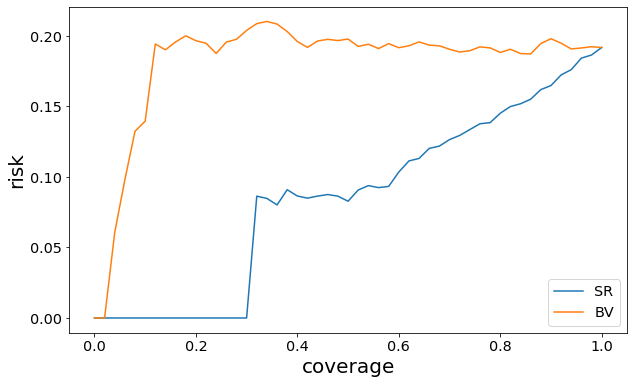

In [21]:
plot(coverages, risks_sr, risks_var, (10,6))

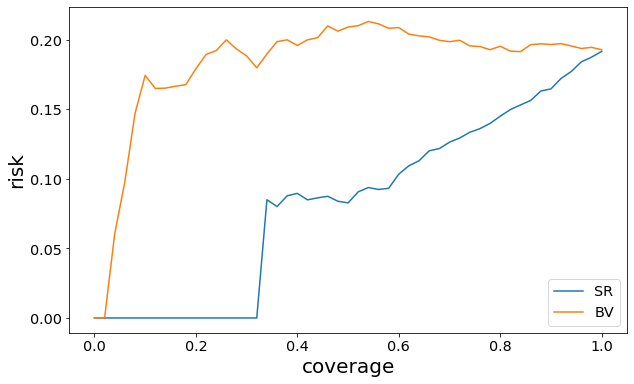

In [24]:
plot(coverages, risks_sr, risks_var, (10,6))

## IMDb

In [25]:
_, valid_data, _ = load_imdb()
iterator = data.BucketIterator(valid_data, batch_size=batch_size, device=device)

91572



In [26]:
saved_folder = './models_final/imdb/'
os.listdir(saved_folder)

['best_lr_lstm_4_val_acc=0.5366.pth',
 'best_lr_tcn_variational_normal_26_val_acc=0.882.pth',
 'best_lr_NO_drop_tcn_28_val_acc=0.8838.pth',
 'best_lr_tcn_28_val_acc=0.8926.pth',
 'best_NO_drop_tcn_3_val_acc=0.8974.pth',
 'best_lstm_variational_normal_15_val_acc=0.8278.pth',
 'best_tcn_3_val_acc=0.8962.pth',
 'best_lstm_variational_laplace_15_val_acc=0.8278.pth',
 'best_tcn_variational_laplace_4_val_acc=0.8904.pth',
 'best_lstm_19_val_acc=0.861.pth',
 'best_lr_tcn_variational_laplace_26_val_acc=0.882.pth',
 'best_lr_NO_drop_lstm_21_val_acc=0.6754.pth',
 'best_tcn_variational_normal_4_val_acc=0.8904.pth',
 'best_lr_lstm_variational_normal_30_val_acc=0.7436.pth',
 'best_lr_lstm_variational_laplace_30_val_acc=0.7436.pth',
 'best_NO_drop_lstm_14_val_acc=0.8596.pth']

In [35]:
name = 'tcn_variational'
[l for l in os.listdir(saved_folder) if name in l]

['best_lr_tcn_variational_normal_26_val_acc=0.882.pth',
 'best_tcn_variational_laplace_4_val_acc=0.8904.pth',
 'best_lr_tcn_variational_laplace_26_val_acc=0.882.pth',
 'best_tcn_variational_normal_4_val_acc=0.8904.pth']

In [37]:
model = torch.load(saved_folder + 'best_tcn_variational_normal_4_val_acc=0.8904.pth')
model.to(device)

TextTCN(
  (embedding): Embedding(91572, 100, padding_idx=1)
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (conv2): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (net): Sequential(
          (0): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
          (4): Chomp1d()
          (5): ReLU()
        )
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (conv2): Conv1dPathwise(100, 100, kernel_size=(3,), stride=(1,

In [47]:
preds, scores, targets, variances = bbb_predict(model, iterator, T=100)
kappas_sr = np.max(scores, 1)
kappas_var = -variances

(5000,)
(5000, 2)
(5000,)
(5000,)


In [48]:
risks_sr = [selective_risk_at_coverage(c, kappas_sr, preds, targets) for c in coverages]
risks_var = [selective_risk_at_coverage(c, kappas_var, preds, targets) for c in coverages]

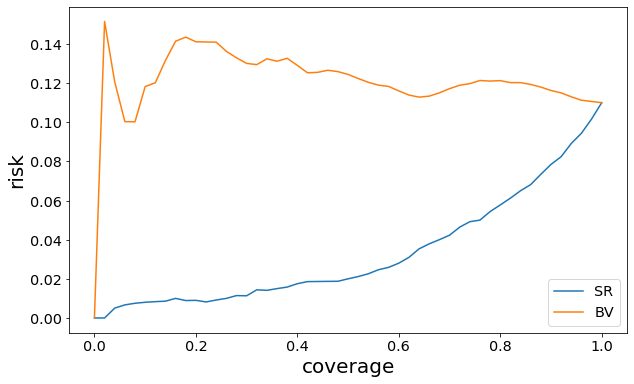

In [49]:
plot(coverages, risks_sr, risks_var, (10,6))

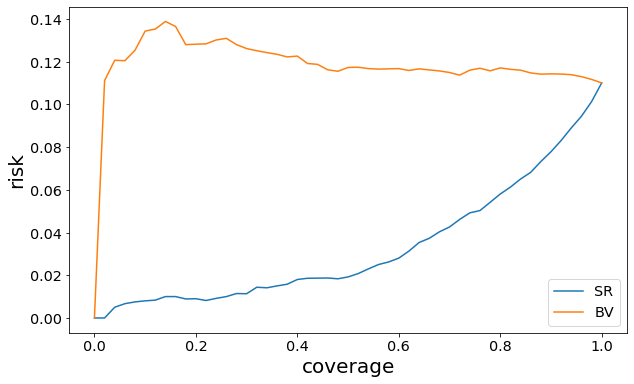

In [46]:
plot(coverages, risks_sr, risks_var, (10,6))

## Yelp-f

In [15]:
_, valid_data, _ = load_yelp()
iterator = data.BucketIterator(valid_data, batch_size=batch_size, device=device)

In [16]:
saved_folder = './models_final/yelp/'
os.listdir(saved_folder)

['best_tcn_variational_normal_1_val_acc=0.6227769.pth',
 'best_lr_tcn_variational_laplace_8_val_acc=0.6158385.pth',
 'best_lstm_variational_normal_2_val_acc=0.6295308.pth',
 'best_lr_tcn_variational_normal_8_val_acc=0.6176769.pth',
 'best_lstm_variational_laplace_2_val_acc=0.6319385.pth',
 'best_lr_lstm_variational_normal_16_val_acc=0.6126.pth',
 'best_lr_lstm_variational_laplace_15_val_acc=0.6104.pth',
 'best_tcn_variational_laplace_2_val_acc=0.6246154.pth']

In [ ]:
model = torch.load(saved_folder + 'best_lr_tcn_variational_normal_8_val_acc=0.6176769.pth')
model.to(device)

In [ ]:
preds, scores, targets, variances = bbb_predict(model, iterator, T=10)
kappas_sr = np.max(scores, 1)
kappas_var = -variances

In [ ]:
risks_sr = [selective_risk_at_coverage(c, kappas_sr, preds, targets) for c in coverages]
risks_var = [selective_risk_at_coverage(c, kappas_var, preds, targets) for c in coverages]

In [ ]:
plt.plot(coverages, risks_sr, label='sr')
plt.plot(coverages, risks_var, label='var')
plt.legend()
plt.show()